In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

Loading the Data

In [3]:
species = pd.read_csv('species_info.csv',encoding='utf-8')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [4]:
observations = pd.read_csv('observations.csv', encoding='utf-8')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


Data Characteristics

In [5]:
print(f"species shape: {species.shape}")
print(f"observations shape: {observations.shape}")

species shape: (5824, 4)
observations shape: (23296, 3)


The number of distinct species in the data

In [6]:
print(f"number of species:{species.scientific_name.nunique()}")

number of species:5541


Find the number of category that are represented in the data

In [7]:
print(f"nnumber of categories:{species.category.nunique()}")
print(f"categories:{species.category.unique()}")

nnumber of categories:7
categories:['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


Count of category in the data

In [8]:
species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

Explore is conservation_status

In [9]:
print(f"number of conservation statuses:{species.conservation_status.nunique()}")
print(f"unique conservation statuses:{species.conservation_status.unique()}")

number of conservation statuses:4
unique conservation statuses:[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


A count of the number of observations in the breakdown of the categories in conservation_status

In [10]:
print(f"na values:{species.conservation_status.isna().sum()}")

print(species.groupby("conservation_status").size())

na values:5633
conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64


To check the number of parks

In [11]:
print(f"number of parks:{observations.park_name.nunique()}")
print(f"unique parks:{observations.park_name.unique()}")

number of parks:4
unique parks:['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


Total number of observations logged in the parks

In [12]:
print(f"number of observations:{observations.observations.sum()}")

number of observations:3314739


Analysis

Nan values were detected. These values will need to be converted to No Intervention

In [13]:
species.fillna('No Intervention', inplace=True)
species.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

Both the table and chart to explore

In [14]:
conservationCategory = species[species.conservation_status != "No Intervention"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservationCategory

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


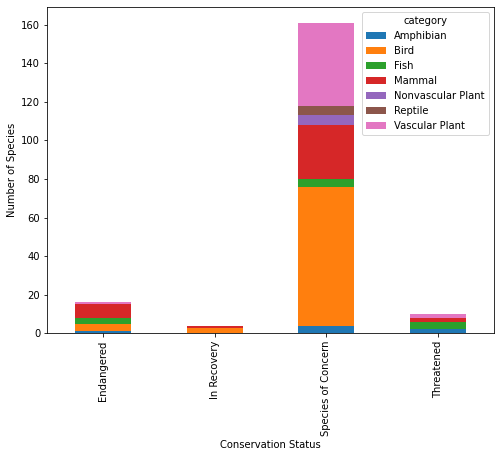

In [15]:
ax = conservationCategory.plot(kind = 'bar', figsize=(8,6), 
                               stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

In [16]:
species['is_protected'] = species.conservation_status != 'No Intervention'

Once the new column is created, group by category and is_protected to show the break down of each species type and protection status.

In [17]:
category_counts = species.groupby(['category', 'is_protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']

category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [18]:
category_counts['percent_protected'] = category_counts.protected / \
                                      (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


Statistical Significance

In [19]:
from scipy.stats import chi2_contingency

contingency1 = [[30, 146],
              [75, 413]]
chi2_contingency(contingency1)

(0.1617014831654557, 0.6875948096661336, 1, array([[ 27.8313253, 148.1686747],
        [ 77.1686747, 410.8313253]]))

In [20]:
contingency2 = [[30, 146],
               [5, 73]]
chi2_contingency(contingency2)

(4.289183096203645, 0.03835559022969898, 1, array([[ 24.2519685, 151.7480315],
        [ 10.7480315,  67.2519685]]))

Species in Parks

In [21]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

common_Names[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [22]:
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [23]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

In [24]:
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
62,Bat,23
158,Shrew,18
30,Myotis,17
97,Mouse,16
131,Chipmunk,13
23,Squirrel,12
1,American,12
149,Vole,11
166,Eastern,11
159,Mountain,10


In [25]:
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)

species.head(10)

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No Intervention,False,False
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",No Intervention,False,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True,False
8,Mammal,Canis lupus,Gray Wolf,Endangered,True,False
9,Mammal,Canis rufus,Red Wolf,Endangered,True,False


In [26]:
species[species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


Next the results of the bat species will be merged with observations to create a DataFrame with observations of bats across the four national parks.

In [27]:
bat_observations = observations.merge(species[species.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


 Total bat observations(across all species) were made at each national park.

In [28]:
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


Each park broken down by protected bats vs. non-protected bat sightings

In [29]:
obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


From this chart one can see that Yellowstone and Bryce National Parks seem to be doing a great job with their bat populations since there are more sightings of protected bats compared to non-protected species

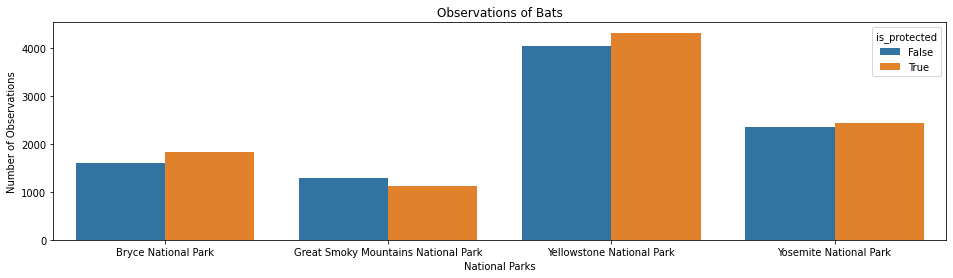

In [31]:
plt.figure(figsize=(16, 4))
sns.barplot(x=obs_by_park.park_name, y= obs_by_park.observations, hue=obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats')
plt.show()